# Week 3: Distributions Continued

## Recall from last week

We are going to continue with our discussion from last week on distributions. To rehash... __there are lots of different distributions__. The most common used in astronomy are the Gaussian (normal), power law, binomial, Poisson, and Lorentz.

When working with a data set we may be faced __two questions__:  
- Is a set of samples consistent with following one of these distributions?  
- Are two sets of samples drawn from the same distribution?  

The tests discussed last week should help us answer these questions. Depending on the situation, __different tests may be appropriate__. The table below should help answer these questions.

### Comparing a data set to a known (analytic) distribution

- $\chi$^2: Widely used, rigorously defined for known, Gaussian uncertainties.
- Kolmogorov-Smirnov (KS): Widely used, compares maximum difference in CDF. Not great for small numbers or outliers.
- Anderson-Darling: Integrated version of the KS test. Therefore better than KS for small numbers and outliers.
- t-test: Determines whether a data set could be consistent with having a mean at some value.

### Comparing two data sets

- Mann-Whitney U (Wilcox rank sum): Assumes nothing about underlying distributions. Really only compares the medians.
- Kolmogorov-Smirnov (KS): Widely used, compares maximum difference in CDF. Not great for small numbers of outliers.
- Anderson-Darling: Integrated version of the KS test. Therefore better than KS for small numbers and outliers.
- t-test: Tests if the means of two (assumed to be Gaussian) distributions equal. Distributions may have different variances - math is slightly different.
- F-test: Tests if the means of two Gaussian distributions are equal.

### Correlation tests

- Pearson r or $\rho$: Widely used, simple to implement. Easily skewed by outliers. Works for linear correlations.
- Spearman r or $\rho$: Handles outliers better. Linear not required -> works for any monotonic function.
- Kendall $\tau$: Also a rank test. Used to determine whether two variables are independent.

## Now, on to a few examples

In [1]:
# First, let's load the libraries we will need
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

### Exercise 1: Characterizing two distributions

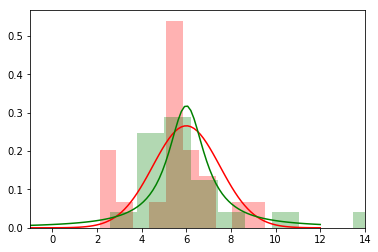

In [74]:
# sample = np.random.normal(loc=4.0, scale=1.5, size=30)
# plt.hist(sample, normed=True)

x = np.linspace(-2, 12.0, 100)


y = stats.norm.pdf(x, loc=6.0, scale=1.5)
plt.plot(x, y, color='r')
y = stats.norm.rvs(loc=6.0, scale=1.5, size=20)
plt.hist(y, normed=True, color='r', 
         alpha=0.3)
np.savetxt("../data/Week_3/sample_1.dat", y)


y = stats.cauchy.pdf(x, loc=6.0, scale=1.0)
plt.plot(x,y, color='g')
y = stats.cauchy.rvs(loc=6.0, scale=1.0, size=20)
plt.hist(y, normed=True, color='g', alpha=0.3)
np.savetxt("../data/Week_3/sample_2.dat", y)


plt.xlim(-1.0, 14.0)
plt.show()

In [77]:
folder = "../data/Week_3/"

sample_1 = np.genfromtxt(folder + "sample_1.dat")
sample_2 = np.genfromtxt(folder + "sample_2.dat")

# Let's see how big the data sets are
print("Data set 1 has", len(sample_1), "elements")
print("Data set 2 has", len(sample_2), "elements")

Data set 1 has 20 elements
Data set 2 has 20 elements


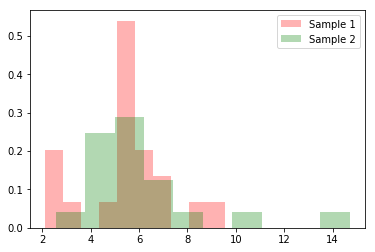

In [80]:
# Now, let's plot histograms of the two data set to see how they compare
plt.hist(sample_1, normed=True, color='r', alpha=0.3, label="Sample 1")
plt.hist(sample_2, normed=True, color='g', alpha=0.3, label="Sample 2")

plt.legend()
plt.show()

First, let's see if these two data sets are consistent with being a Gaussian. Let's start with Sample 1.

In [85]:
# We will use the Anderson-Darling test in the scipy package.

statistic, critical_values, significance = stats.anderson(sample_1, dist='norm')

print("Statistic =", statistic)
print("Critical values =", critical_values)
print("Significance =", significance)

Statistic = 0.685250007509
Critical values = [ 0.506  0.577  0.692  0.807  0.96 ]
Significance = [ 15.   10.    5.    2.5   1. ]


Since the statistic, 0.685, is larger than 0.577 but smaller than 0.692, the distribution is non-Gaussian only at the 90% to 95% level. The statistic would have to be above 0.96 to be ruled non-Gaussian at the 99% level.

In [84]:
# In this code cell, repeat the same test above with Sample 2




Now, let's compare the two distributions to each other. Pick two of the tests above and apply them. 

Remember that in jupyter, it is easy to look up the docs for packages and functions. Look at the following code blocks examples.

In [3]:
stats?

In [88]:
stats.uniform?

In [96]:
statistic, critical_values, significance = stats.anderson_ksamp([sample_1, sample_2])
print("Anderson-Darling Test:")
print("Statistic =", statistic)
print("Critical values =", critical_values)
print("Significance =", significance)
print()

statistic, p_value = stats.ks_2samp(sample_1, sample_2)
print("Kolmogorov-Smirnov:")
print("Statistic =", statistic)
print("p-value =", p_value)

Anderson-Darling Test:
Statistic = -0.473498369492
Critical values = [ 0.325  1.226  1.961  2.718  3.752]
Significance = 0.5729511648872668

Kolmogorov-Smirnov:
Statistic = 0.25
p-value = 0.497342335314


/usr/local/lib/python3.5/dist-packages/scipy/stats/morestats.py:1685: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


### Example 2: Using radial velocities to constrain an unseen companion to a star

This is an example from my own research (see Andrews et al. 2016). 

Let's say you have a star that looks strange for some reason, and you want to know that could be because the star is actually a binary system. A faint companion will not appear in the photometry or spectroscopy. However, by taking several consecutive measurements of the radial velocity the possibility that the star hosts a companion can be constrained.

First, let's load up the radial velocity data and look at it.

In [3]:
folder = "../data/Week_3/"

RV_1 = np.genfromtxt(folder + "RV_sample_1.dat", names=True)

print(RV_1.dtype)

[('date', '<f8'), ('vel', '<f8'), ('err', '<f8'), ('filename', '<f8')]


In [4]:
# Our RV plotting script

def generate_RV_plot(times, RV, RV_err, xmin=None, xmax=None, color='k', ax=None, 
                     xlabel=None, ylabel=None, label=None):
    
    if ax is None:
        if label is None:
            plt.errorbar(times, RV, yerr=RV_err, fmt='o', color=color)
        else:
            plt.errorbar(times, RV, yerr=RV_err, fmt='o', color=color, label=label)
            
        if xmin is not None and xmax is not None: plt.xlim(xmin, xmax)
        if xlabel is not None: plt.xlabel(xlabel)
        if ylabel is not None: plt.ylabel(ylabel)
        
    else:
        if label is None:
            ax.errorbar(times, RV, yerr=RV_err, fmt='o', color=color)
        else:
            ax.errorbar(times, RV, yerr=RV_err, fmt='o', color=color, label=label)  
            
        if xmin is not None and xmax is not None: ax.set_xlim(xmin,xmax)
        if xlabel is not None: ax.set_xlabel(xlabel)
        if ylabel is not None: ax.set_ylabel(ylabel)
        

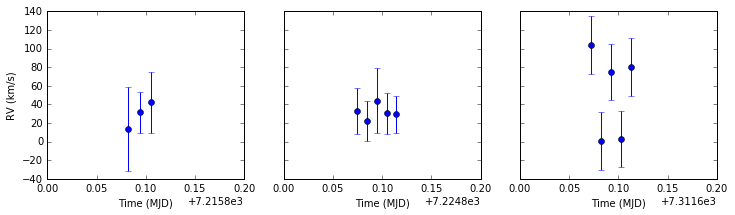

In [19]:
# Now, we plot the three different sets of observations

fig, ax = plt.subplots(1, 3, figsize=(12,3), sharey=True)

# First observation
generate_RV_plot(RV_1["date"], RV_1['vel'], RV_1['err'], xmin=7215.8, xmax=7216.0, color='b', 
                 ax=ax[0], xlabel='Time (MJD)', ylabel='RV (km/s)')

# Second observation
generate_RV_plot(RV_1["date"], RV_1['vel'], RV_1['err'], xmin=7224.8, xmax=7225.0, color='b', 
                 ax=ax[1], xlabel='Time (MJD)')

# Third observation
generate_RV_plot(RV_1["date"], RV_1['vel'], RV_1['err'], xmin=7311.6, xmax=7311.8, color='b', 
                 ax=ax[2], xlabel='Time (MJD)')



This data were taken with the FLWO 1.5-meter telescope, not the VLT, so the radial velocities are not super precise. But we can still use it: For instance, the last observation shows what could be periodic oscillations indicative of the orbital motion of a short period binary. However, these are not seen in the other two observations. Likewise, the first observation looks like it could indicate a slow increase in the radial velocity, but the other two observations do not clearly show anything similar. 

**So, how do we deal with this data?**

To really squeeze every last bit of information out of this data, we'll need to use time series analysis. Since that is (maybe) the subject of a future session, we'll ignore it for now. Instead, let's perform the first order analysis, using **hypothesis testing.** Here's how it goes.

We adopt the following *null hypothesis*:

**Hypothesis: These radial velocities have no variations**

Now, we ask the question: how likely is it that these data are consistent with the null hypothesis? The goal is to be able to reject the null hypothesis with some statistical significance. We will adopt a **p** value (in much scientifical and medical literature, a critical **p** value of 0.05 is used)

An easy way to answer this question is by calculating the $\chi^2$ value, or more specifically, the reduced $\chi^2$ value. The following equation may look familiar:

$$ \chi^2_{\rm red} = \frac{1}{N-k} \sum_{i=1}^{N} \left( \frac{y_i - \mu}{\sigma_i} \right)^2, $$

where $N$ is the number data points, $k$ are the number of model parameters, $y_i$ and $\sigma_i$ are the radial velocities and their associated uncertainties, respectively, and $\mu$ is the average radial velocity. 

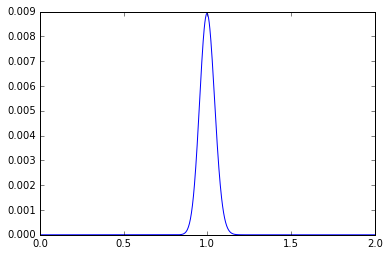

In [68]:

def get_chi_2_pdf(x_vals, N_data):
    
    sample_data = np.random.normal(size=N_data)

    dist = stats.chi2(N_data)
    return dist.pdf(x_vals)


ran_x = np.linspace(0.0, 2.0*N_data, 1000)
ran_y = get_chi_2_pdf(ran_x, 1000)

plt.plot(ran_x/N_data, dist.pdf(ran_x))
plt.show()

### Question: What is the value of $k$ in the above equation, and why?

**Answer:** Since we do not know the actual radial velocity of the star, $\mu$, it must be determined by the data. We have one less degree of freedom, so $k=1$

First, let's calculate $\mu$. For heteroscedastic data (each data point has its own associated uncertainty), we need to use a weighted mean in which the weights are the inverse of $\sigma_i^2$. Use the function below to calculate the weighted mean, and replot the RV data with the weighted mean shown in the background.

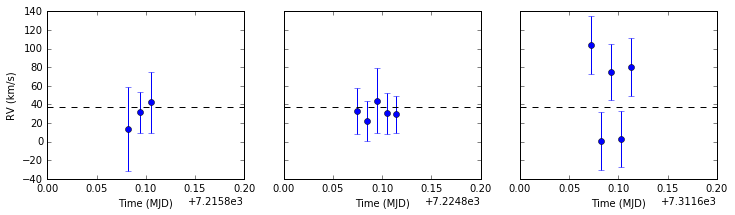

In [22]:
# Again, we plot the three different sets of observations
fig, ax = plt.subplots(1, 3, figsize=(12,3), sharey=True)


# Calculate and plot the weighted mean
mu_1 = np.average(RV_1['vel'], weights=1.0/RV_1['err']**2)

for a in ax:    
    a.axhline(mu_1, color='k', linestyle='--')



# First observation
generate_RV_plot(RV_1["date"], RV_1['vel'], RV_1['err'], xmin=7215.8, xmax=7216.0, color='b', 
                 ax=ax[0], xlabel='Time (MJD)', ylabel='RV (km/s)')

# Second observation
generate_RV_plot(RV_1["date"], RV_1['vel'], RV_1['err'], xmin=7224.8, xmax=7225.0, color='b', 
                 ax=ax[1], xlabel='Time (MJD)')

# Third observation
generate_RV_plot(RV_1["date"], RV_1['vel'], RV_1['err'], xmin=7311.6, xmax=7311.8, color='b', 
                 ax=ax[2], xlabel='Time (MJD)')

plt.show()

With a partner, **code up a function** that takes in the measurement values, their uncertainties, and returns $\chi_{\rm red}^2$ using the equation provided. Start by adapting the line in the above block of code that calculates $\mu$ to the inputs in the function below.

In [5]:
def calc_reduced_chi_2(y, y_err):
    
    # Calculate the weighted mean
    mu = np.average(y, weights=1.0/y_err**2)

    # Number of data points
    N_data = len(y)
    
    # Calculate the reduced chi^2
    reduced_chi_2 = 1. / (N_data - 1) * np.sum(((y-mu)/y_err)**2)
            
    return reduced_chi_2

In [6]:
reduced_chi_2 = calc_reduced_chi_2(RV_1['vel'], RV_1['err'])
print("Reduced chi^2:", reduced_chi_2)


('Reduced chi^2:', 0.92115096625944848)


For "perfectly" random data, $\chi_{\rm red}^2$ should be unity. The data here are pretty close. To quantify this statement, we want to calculate the **p** value we discussed above. Use the code block below to calculate this.

In [56]:
N_dof = 1  # Number of degrees of freedom

p_value = stats.chi2.cdf(reduced_chi_2, N_dof)
print p_value

0.662827052509


How do we interpret this number? Had **p** been greater than 0.95, it would have indicated that the data are *too* consistent given the uncertainties. Typically this means the uncertainties are overestimated for some reason. Had the **p** value been less than 0.05, it would have indicated that our null hypothesis could have been ruled out at the 95% (or roughly 2-$\sigma$) level. Practically speaking, this means that only 5% of the time (or 1 in 20), could a result with this level of consistency have been randomly generated.

Note that, depending on what you are doing, a **p** value of 0.05 may not be stringent enough. The annals of particle physics history are replete with 3-$\sigma$ detections (**p** < 0.01), only to be later shown as noise.

So, our conclusion from this exercise is the following: **Given the p value of 0.66, we cannot rule out the null hypothesis. Therefore, our data are consistent with non-varying radial velocities.**

### Example 3: But wait, there's a second star!

The star we have been looking has a wide binary companion, and we have radial velocity data for both. Load up the data below, and plot both RV's together, along with each of their means.

In [7]:
# Load the radial velocity data for star 2
RV_2 = np.genfromtxt(folder + "RV_sample_2.dat", names=True)

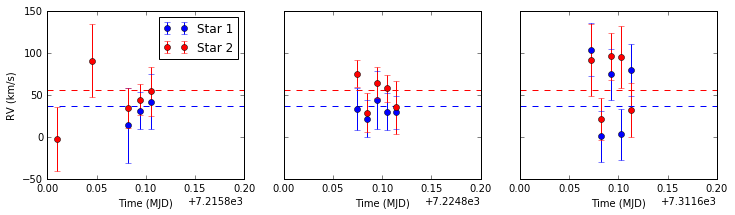

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(12,3), sharey=True)


# Calculate and plot the weighted mean
mu_1 = np.average(RV_1['vel'], weights=1.0/RV_1['err']**2)
mu_2 = np.average(RV_2['vel'], weights=1.0/RV_2['err']**2)

for a in ax:    
    a.axhline(mu_1, color='b', linestyle='--')
    a.axhline(mu_2, color='r', linestyle='--')



# First observation
generate_RV_plot(RV_1["date"], RV_1['vel'], RV_1['err'], xmin=7215.8, xmax=7216.0, color='b', 
                 ax=ax[0], xlabel='Time (MJD)', ylabel='RV (km/s)', label='Star 1')
generate_RV_plot(RV_2["date"], RV_2['vel'], RV_2['err'], color='r', ax=ax[0], label='Star 2')

# Second observation
generate_RV_plot(RV_1["date"], RV_1['vel'], RV_1['err'], xmin=7224.8, xmax=7225.0, color='b', 
                 ax=ax[1], xlabel='Time (MJD)')
generate_RV_plot(RV_2["date"], RV_2['vel'], RV_2['err'], color='r', ax=ax[1])

# Third observation
generate_RV_plot(RV_1["date"], RV_1['vel'], RV_1['err'], xmin=7311.6, xmax=7311.8, color='b', 
                 ax=ax[2], xlabel='Time (MJD)')
generate_RV_plot(RV_2["date"], RV_2['vel'], RV_2['err'], color='r', ax=ax[2])


# Add the legend
ax[0].legend()



plt.show()

In the code block below, perform the same analysis that we did above for Star 1, to determine if Star 2 is consistent with the null hypothesis of zero variability.

In [61]:
reduced_chi_2 = calc_reduced_chi_2(RV_2['vel'], RV_2['err'])
print("Reduced chi^2:", reduced_chi_2)

N_dof = 1  # Number of degrees of freedom

p_value = stats.chi2.cdf(reduced_chi_2, N_dof)
print p_value

('Reduced chi^2:', 1.0962551609110849)
0.704910588729


We can conclude that Star 2 is also consistent with the null hypothesis.

### Wait a second...

...this is supposed to be a binary, but the radial velocities above are different. Is this difference significant? Again, we can use hypothesis testing.

### Question: What is the null hypothesis? How can we test it using the tools we've discussed thus far? Once you have a plan, go ahead and calculate a p-value.

**Answer:** Our null hypothesis is that the two stars are part of a binary and therefore should have the same radial velocity. There are several ways in which we can test our null hypothesis. 

#### Method 1: assuming **all** of the radial velocity measurements are of the binary center of mass and calculate the $\chi_{\rm red}^2$ using the same formula as above.

In [11]:
RV_all = np.append(RV_1['vel'], RV_2['vel'])
RV_all_err = np.append(RV_1['err'], RV_2['err'])

reduced_chi_2 = calc_reduced_chi_2(RV_all, RV_all_err)
print("Reduced chi^2:", reduced_chi_2)

N_dof = 1
p_value = stats.chi2.cdf(reduced_chi_2, N_dof)
print p_value

('Reduced chi^2:', 1.1245545744533336)
0.711060154263


#### Method 2: Find the two weighted means and standard deviations on those means. See how different the two Gaussians actually are.

The uncertainty of weighted data can be calculated straightforwardly. Again, the weights are $\sigma_i^{-2}$: 

$$\sigma^2 = \frac{ \sum_{i=1}^N \left( \frac{\mu - y_i}{\sigma_i^2} \right)^2 }{\sum_{i=1}^N \frac{1}{\sigma_i^2}} $$

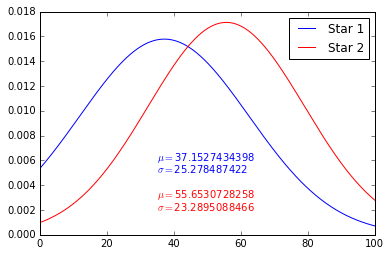

In [34]:
mu_1 = np.average(RV_1['vel'], weights=1.0/RV_1['err']**2)
mu_2 = np.average(RV_2['vel'], weights=1.0/RV_2['err']**2)

sd_1 = np.sqrt(np.sum(1./RV_1['err']**2 * (RV_1['vel']-mu_1)**2) / np.sum(1./RV_1['err']**2))
sd_2 = np.sqrt(np.sum(1./RV_2['err']**2 * (RV_2['vel']-mu_2)**2) / np.sum(1./RV_2['err']**2))

gaussian_1 = stats.norm(loc=mu_1, scale=sd_1)
gaussian_2 = stats.norm(loc=mu_2, scale=sd_2)

ran_x = np.linspace(0, 100, 1000)

plt.plot(ran_x, gaussian_1.pdf(ran_x), label='Star 1', color='b')
plt.plot(ran_x, gaussian_2.pdf(ran_x), label='Star 2', color='r')



plt.text(35, 0.006, r'$\mu =$'+str(mu_1), color='b')
plt.text(35, 0.005, r'$\sigma =$'+str(sd_1), color='b')

plt.text(35, 0.003, r'$\mu =$'+str(mu_2), color='r')
plt.text(35, 0.002, r'$\sigma =$'+str(sd_2), color='r')


plt.legend()
plt.show()

Now, we can answer the question. The difference in the two radial velocities is $\Delta \mu = \mu_1 - \mu_2$. Using error propagation (which we will learn next week), the uncertainty on that difference is $\sigma_{\Delta \mu} = \sqrt{\sigma_1^2 + \sigma_2^2}$. 

So $\Delta \mu = -18.5\pm34.4$

Our null hypothesis is now that $\Delta \mu = 0$. So, the difference between the observed $\Delta \mu$ and the null hypothesis is less than 1$\sigma$, but let's calculate the associated **p**-value anyway. This can be done straightforwardly by evaluating the cumulative distribution function of a Gaussian with a mean of $\Delta \mu$ and a standard deviation of $\sigma_{\Delta \mu}$. 

In [39]:
gaussian_rv_diff = stats.norm(loc=-18.5, scale=34.4)
print "p-value:", gaussian_rv_diff.cdf(0.0)

p-value: 0.704639222584


It is worth considering why this **p**-value is different from that calculated using method 1 above.

## The Central Limit Theorem (CLT)

Sample from an arbitrary distribution f(x), say N samples, and take their mean. The mean will not necessarily be the same as the mean of f(x). But if you repeat this a number of times, you'lee see that the sample means are distributed *normally* around the mean of f(x) with a standard deviation: $\sigma_N = \sigma_{f(x)}/\sqrt{N}$, where $\sigma_{f(x)}$ is the spread of the original distribution.

Assumptions: 
* initial distribution has well-defined standard deviation (tails fall of more rapidly than $x^{-2}$)
* data are uncorrelated

### CLT example

How does the spread of the sample mean change with the number of samples N? Let's compare the distributions of the sample means for N = 20 and N = 100. Let's also see how the spread of these distributions varies as a function of N.

In [33]:
# Select mean and spread of parent distribution f(x)
parent_mean = 6.0
parent_spread = 1.5

# Number of samples to average
Nsize_1 = 15

# define empty list to store sample means
sample_means = []

# Draw samples several times to see distribution
Nrepeats = 1000
for i in range(Nrepeats):
    # draw Nsize samples
    y = stats.norm.rvs(loc=parent_mean, scale=parent_spread, size=Nsize_1)
    # compute their mean
    y_mean = np.mean(y)
    # collect mean in a list
    sample_means.append(y_mean)
    
# Now select other number of samples to compare
Nsize_2 = 100
# define empty list to store sample means
sample_means_2 = []
for i in range(Nrepeats):
    y = stats.norm.rvs(loc=parent_mean, scale=parent_spread, size=Nsize_2)
    y_mean = np.mean(y)
    sample_means_2.append(y_mean)
    
# How does the spread of the distribution of sample means change with sample size N?
# To explore this dependence, select several sample sizes 
Ns = [5,10,50,100,200,500]
spread_N = []
for N in Ns:
    sample_means_i = []
    # Repeat drawing samples and averaging this many times
    Nrepeats = 100
    for i in range(Nrepeats):
        # draw N samples
        y = stats.norm.rvs(loc=parent_mean, scale=parent_spread, size=N)
        # compute their mean
        y_mean = np.mean(y)
        # collect mean in a list
        sample_means_i.append(y_mean)
    spread_N.append(np.std(sample_means_i))

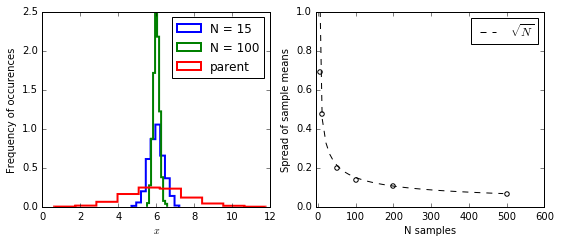

In [47]:
# Plot histogram of sample means for both cases of N
fig, ax = plt.subplots(1,2, figsize = (9,3.5))
ax[0].hist(sample_means, histtype = 'step', label = 'N = %d'%Nsize_1,  bins = 10, normed = True, linewidth=2)
ax[0].hist(sample_means_2, histtype = 'step', label = 'N = %d'%Nsize_2,  bins = 10,normed = True, linewidth=2)
# plot also original distribution
ax[0].hist(stats.norm.rvs(loc=parent_mean, scale=parent_spread, size=2000), 
           histtype = 'step', label = 'parent', normed = True, linewidth=2)
ax[0].legend(loc = 1)
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Frequency of occurences')
ax[0].set_ylim(ymax = 2.5)

# Plot spread of sample means versus N samples
ax[1].scatter(Ns, spread, facecolor = 'w')
xs = np.arange(1,max(Ns),10)
ax[1].plot(xs, parent_spread/np.sqrt(xs), ls = 'dashed', c = 'k', label = '$\sqrt{N}$')
ax[1].set_ylabel('Spread of sample means')
ax[1].set_xlabel('N samples')
ax[1].set_xlim(xmin = -5)
ax[1].set_ylim(ymin = 0,ymax = 1)
ax[1].legend()

plt.show()

Bonus: the more you repeat the excercise, the more the distribution of sample means approaches Gaussianity (repeat with 500 iterations).

### Exercise: Show the CLT holds for the uniform distribution

Let's apply the CLT to the uniform distribution, using **x_min=5** and **x_max=26**. 

### Question: The CLT implies that the distribution of sample means converges on one value in the limit of large N. What is that value for this paticular uniform distribution?

**Answer:** (x_max+x_min)/2, or 15.5

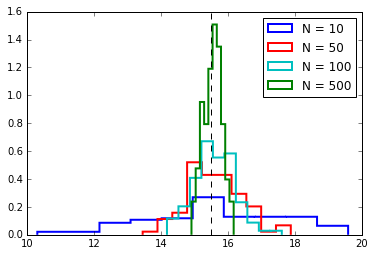

In [93]:
x_min, x_max = 5, 26

convergence_value = (x_max + x_min)/2.0

Ns = [10,50,100,500]
colors = ['b','r','c','g','y','g']

spread = []
for j, N in zip(range(len(Ns)), Ns):
    sample_means = []
    # Repeat drawing samples and averaging this many times
    Nrepeats = 100
    for i in range(Nrepeats):
        
        # draw N samples from the random uniform distribution and calculate the mean
        y = np.random.uniform(x_min, x_max, size=N)
        y_mean = np.mean(y)
        sample_means.append(y_mean)

    spread.append(np.std(sample_means))
    
    plt.hist(sample_means, normed=True, histtype='step', color=colors[j], 
             label='N = '+str(N), linewidth=2)

    
plt.axvline(convergence_value, color='k', linestyle='--')

plt.legend()
    
plt.show()

### Exercise: Show that as you increase the number of sample means (Nrepeats), their distribution approaches a Gaussian. To what value will its spread converge in the limit of large Nrepeats?

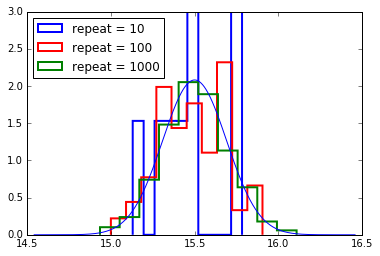

In [54]:
x_min, x_max = 5, 26

convergence_value = (x_max + x_min)/2.0

Nsize = 1000
Nrepeats = [10, 100, 1000]
colors = ['b','r','g']

spread = []
for j, N in zip(range(len(Nrepeats)), Nrepeats):
    sample_means = []
    # Repeat drawing samples and averaging this many times
    for i in range(N):
        # draw N samples from the random uniform distribution and calculate the mean
        y = np.random.uniform(x_min, x_max, size=Nsize)
        y_mean = np.mean(y)
        sample_means.append(y_mean)
        spread.append(np.std(sample_means))
    plt.hist(sample_means, normed=True, histtype='step', color=colors[j], 
             label='repeat = '+str(N), linewidth=2)

plt.legend(loc = 2)

# Show the Gaussian to which the distribution should converge
mu = (x_min+x_max)/2.0
sigma = (x_max-x_min) / np.sqrt(12.) / np.sqrt(Nsize)
tmp_x = np.linspace(mu-5.0*sigma, mu+5.0*sigma, 10000)
tmp_y = stats.norm.pdf(tmp_x, loc=mu, scale=sigma)
plt.plot(tmp_x,tmp_y)
plt.ylim(ymax = 3)
plt.show()